Dadas las series temporales obtenidas de MeteoCdG (meteocdg.uca.es) para el periodo 24-04 al 30-04, a las que se les han borrado datos. Se pide:

- Reconstruir la serie de datos de la forma más precisa posible.
- Tasar el error cometido en la reconstrucción con el MAE y RMSE, usando como referencia la serie de datos completa. Realice ambos estadísticos tanto para la serie completa como para los datos reconstruidos exclusivamente.
- Informe en el que se explique el procesado o técnica empleada y su justificación.

Puedes usar todas las variables y estaciones meteorológicas de MeteoCdG que consideres necesarias, excepto de la estación a completar.

In [1]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `c:\Users\ayats\Documents\ici-reconstruct`


In [2]:
using CSV, DataFrames, DataFramesMeta, StatsPlots
import Dates

macro head(in)
    quote
        display(@view $in[1:5, :])
    end
end

macro plot✨()
    quote
        xlabel!("Date")
        ylabel!("Temperature (°C)")
        plot!(legend=:outertop)
    end
end
;

Row,ts,temp,ts_unix
,DateTime,Float64,Float64
1,2023-04-24T00:00:00,18.45,1.68229e9
2,2023-04-24T00:10:00,18.55,1.6823e9
3,2023-04-24T00:20:00,18.45,1.6823e9
4,2023-04-24T00:30:00,17.93,1.6823e9
5,2023-04-24T00:40:00,17.39,1.6823e9


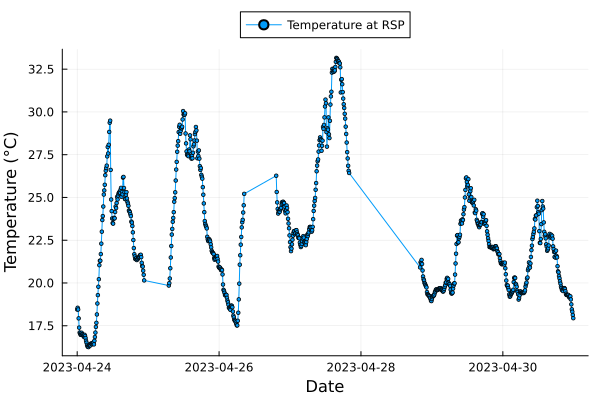

In [3]:
df = @chain CSV.read(
    "data/Temperatura de Río San Pedro desde 2023-04-24 hasta 2023-04-30 - missingdata.csv",
    DataFrame;
    normalizenames=true,
    dateformat="yyyy-mm-dd HH:MM:SS",
) begin
    @select(:ts, :temp = :Temperatura_ºC_)
    @transform(@byrow :ts_unix = Dates.datetime2unix(:ts))
end

@head df

@df df plot(:ts, :temp, label="Temperature at RSP", marker=:circle, markersize=2)
@plot✨

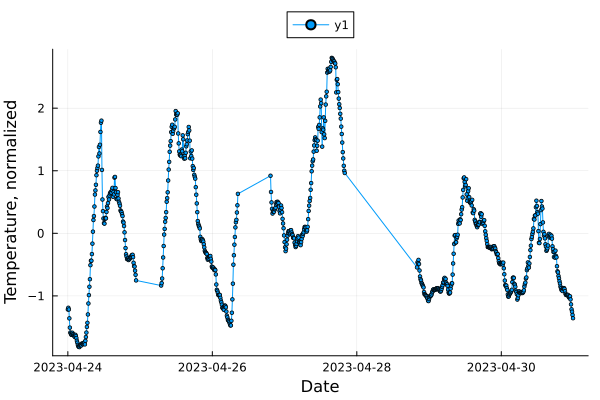

In [4]:
using Statistics

μ = mean(df[:, :temp])
σ = std(df[:, :temp])
@transform!(df, @byrow :temp_norm = (:temp - μ) / σ)

@df df plot(:ts, :temp_norm, marker=:circle, markersize=2)
@plot✨
ylabel!("Temperature, normalized")

Row,ts,temp_norm
,DateTime,Float64
1,2023-04-24T22:50:00,NaN
2,2023-04-24T23:00:00,NaN
3,2023-04-24T23:10:00,NaN
4,2023-04-24T23:20:00,NaN
5,2023-04-24T23:30:00,NaN


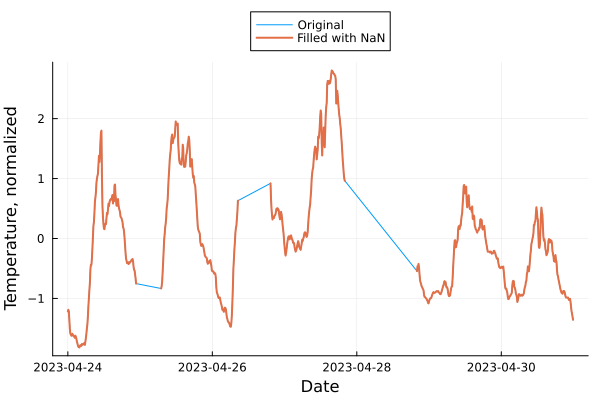

In [5]:
df_resampled = DataFrame(ts=range(
    df[:, :ts] |> minimum,
    df[:, :ts] |> maximum,
    step=Dates.Minute(10)
))

@transform!(df_resampled, @byrow :temp_norm = begin
    same_time = filter(row -> row.ts == :ts, df, view=true)

    if nrow(same_time) == 1
        return same_time.temp_norm[1]
    else
        return NaN
    end
end)


@head @subset(df_resampled, isnan.(:temp_norm))


@df df plot(:ts, :temp_norm, label="Original")
@df df_resampled plot!(:ts, :temp_norm, linewidth=2, label="Filled with NaN")
@plot✨
ylabel!("Temperature, normalized")

SARIMA(2, 0, 3)x(0, 0, 0, 0) with zero mean    

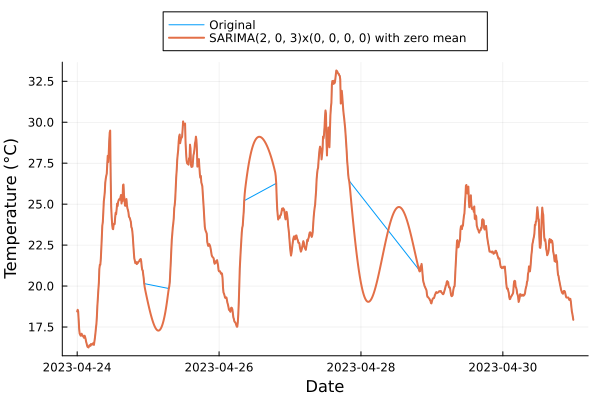

In [6]:
using StateSpaceModels

model = auto_arima(df_resampled.temp_norm)
fit!(model)
display(model)

smoother_output = kalman_smoother(model)

df_resampled[!, :temp_norm_predict] = get_smoothed_state(smoother_output)[:, 1]
@transform!(df_resampled, @byrow :temp = :temp_norm_predict * σ + μ)

plot()
@df df plot!(:ts, :temp, linewidth=1, label="Original")
@df df_resampled plot!(:ts, :temp, linewidth=2, label=repr(model))
@plot✨

Row,ts,temp
,DateTime,Float64
1,2023-04-24T00:00:00,18.45
2,2023-04-24T00:10:00,18.55
3,2023-04-24T00:20:00,18.45
4,2023-04-24T00:30:00,17.93
5,2023-04-24T00:40:00,17.39


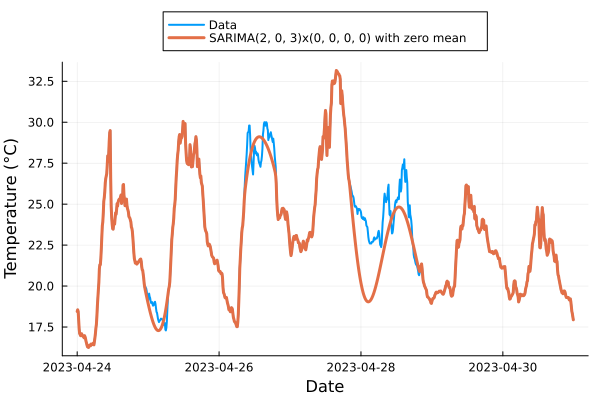

In [7]:
df_real = @chain CSV.read(
    "data/Temperatura de Río San Pedro desde 2023-04-24 hasta 2023-04-30 - original.csv",
    DataFrame;
    normalizenames=true,
    dateformat="yyyy-mm-dd HH:MM:SS",
) begin
    @select(:ts, :temp = :Temperatura_ºC_)
end

@head df_real

plot()
@df df_real plot!(:ts, :temp, linewidth=2, label="Data")
@df df_resampled plot!(:ts, :temp, linewidth=3, label=repr(model))
@plot✨

In [8]:
import StatsBase

df_both = innerjoin(
    @select(df_real, :ts, :temp_real = :temp), 
    @select(df_resampled, :ts, :temp_resampled = :temp, :temp_norm), 
    on=:ts
)

@head df_both

Row,ts,temp_real,temp_resampled,temp_norm
,DateTime,Float64,Float64,Float64
1,2023-04-24T00:00:00,18.45,18.45,-1.21706
2,2023-04-24T00:10:00,18.55,18.55,-1.18972
3,2023-04-24T00:20:00,18.45,18.45,-1.21706
4,2023-04-24T00:30:00,17.93,17.93,-1.35921
5,2023-04-24T00:40:00,17.39,17.39,-1.50682


In [9]:
errors_full = df_both |>
    (x -> full_range_errors = Dict(
        "mae" => StatsBase.meanad(x.temp_real, x.temp_resampled),
        "rmse" => StatsBase.rmsd(x.temp_real, x.temp_resampled),
    ))

Dict{String, Float64} with 2 entries:
  "rmse" => 1.01178
  "mae"  => 0.401473

In [10]:
errors_resample = df_both |>
    (x -> @subset(x, isnan.(:temp_norm))) |>
    (x -> full_range_errors = Dict(
        "mae" => StatsBase.meanad(x.temp_real, x.temp_resampled),
        "rmse" => StatsBase.rmsd(x.temp_real, x.temp_resampled),
    ))

Dict{String, Float64} with 2 entries:
  "rmse" => 2.00769
  "mae"  => 1.58079